<a href="https://colab.research.google.com/github/harmonicfunc/LogicalRhythm2k23/blob/main/LR_ps4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'anyas-gojo-revival-space-shop:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F63364%2F6967454%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240405%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240405T180446Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3f200cd7318a7c4bddc4c0b4528cb1557523eb050a4a46070ca5ec22de1fc44623da6ff019613d2b45027c1f30552007e238c73e73b6feed4a7d8d303b2ec2e54f7f443964cac0f43f970d25e16df96657785575bf690c6fc39e14dd57d30cabd6e3251098ab580684b22fb06d991c37551306675179d84dc2d803cc0313d4cff9386540192b254ffb0891dfd06480557fa149345e6458aec0e9e1aaf8c59432217fcb05726c300ebf28e10640ba2007843bd8156d48f03b3cdab40b374ac8efa411bb57540043ff4f324ceb81d2fa9fce88922d6f52686c90299ddcc71523133b74494287291f45e4bb920566d586608757a18869477d278f98b7c77d955314'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 339992 bytes downloaded
Downloaded and uncompressed: anyas-gojo-revival-space-shop
Data source import complete.


In [2]:
#### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anyas-gojo-revival-space-shop/train.tsv
/kaggle/input/anyas-gojo-revival-space-shop/sample_submission.csv
/kaggle/input/anyas-gojo-revival-space-shop/test.tsv


In [3]:
import re
import spacy
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import string

In [4]:
df = pd.read_csv('/kaggle/input/anyas-gojo-revival-space-shop/train.tsv', sep= '\t')
df

,date,time,id,reviewer name,reviewer address,contact number,variation,verified_reviews,sentiment,feedback
0,30-Jul-18,02:16:00,5138527,Theresa Diaz,"2373 Long Mews\nSouth Lorraine, FL 83715",7445448464,Black Plus,Love my new Echo Plus,5,1
1,30-Jul-18,20:13:24,7881409,Michael Wagner,"34120 James Well Apt. 930\nSouth Kenneth, AK 5...",(202)233-6662,Configuration: Fire TV Stick,Works really well.,5,1
2,29-Jul-18,03:20:48,5658396,Erin Rodriguez,"7996 Booth Mission\nTaylorport, AL 13457",(219)882-0705,Black Show,Echo Show is said to work with certain apps bu...,2,0
3,30-Jul-18,22:48:21,4317957,Christine Perez,USS Schaefer\nFPO AA 86432,291-900-6087,Heather Gray Fabric,Very cool product. Speaker sounds good with my...,5,1
4,23-Jul-18,12:36:42,7570569,Jamie Davila,"000 Kevin Cliffs Suite 674\nBrennanview, NM 77690",9527296610,Black Plus,So far I love it. It was easy to set up - if ...,5,1
...,...,...,...,...,...,...,...,...,...,...
2515,12-Jun-18,14:34:57,40769,Dennis Wells,"416 Murphy Hill Suite 083\nPort Garyshire, RI ...",4454701228,Black,Bought this for my son and it didn’t work. He ...,1,0
2516,30-Jul-18,21:46:21,7343959,Jennifer Lutz,"46716 Jackson Common Suite 050\nWest Stephen, ...",(798)227-0483,Black Dot,Alexa is phenomenal!,5,1
2517,30-Jul-18,14:57:44,2100710,Kevin Hanson,"724 Miller Center Apt. 352\nSouth Maurice, ND ...",(472)841-0473,Heather Gray Fabric,The sound is amazing and many collections of a...,5,1
2518,28-Jul-18,18:09:07,6703141,Justin Schneider,"149 Hall Valleys Suite 629\nBryantown, NV 69983",270-658-6063,Black Show,Love how it shows the song info on the screen ...,5,1


In [5]:
train_df = df.loc[:, ['verified_reviews', 'sentiment']]
train_df

,verified_reviews,sentiment
0,Love my new Echo Plus,5
1,Works really well.,5
2,Echo Show is said to work with certain apps bu...,2
3,Very cool product. Speaker sounds good with my...,5
4,So far I love it. It was easy to set up - if ...,5
...,...,...
2515,Bought this for my son and it didn’t work. He ...,1
2516,Alexa is phenomenal!,5
2517,The sound is amazing and many collections of a...,5
2518,Love how it shows the song info on the screen ...,5


# EDA

In [6]:
train_df.describe()

,sentiment
count,2520.000000
mean,4.455556
std,1.072042
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [7]:
train_df.isnull().sum()

verified_reviews    1
sentiment           0
dtype: int64

In [8]:
train_df.dropna(inplace = True)
train_df.isnull().sum()

verified_reviews    0
sentiment           0
dtype: int64

In [9]:
train_df['sentiment'].unique()

array([5, 2, 3, 4, 1])

In [10]:
train_df['sentiment'].value_counts(normalize=True)

sentiment
5    0.720921
4    0.147678
1    0.052005
3    0.050417
2    0.028980
Name: proportion, dtype: float64

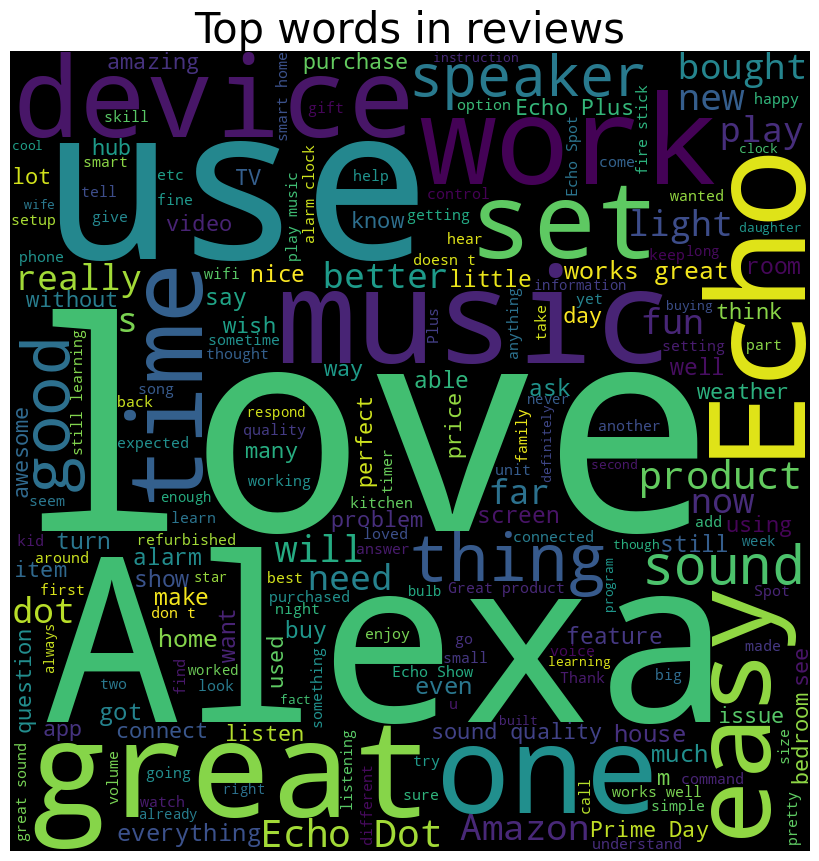

In [11]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title,fontsize=30)
    plt.show()
wordCloud_generator(train_df['verified_reviews'], title="Top words in reviews")

In [12]:
X = train_df['verified_reviews'].copy()
y = train_df['sentiment'].copy()

In [13]:
encoding = {1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 4
           }
labels = ['1', '2', '3', '4', '5']

y = train_df['sentiment'].copy()
y.replace(encoding, inplace=True)
y = to_categorical(y,5)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42,test_size=0.1)

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
max_length = max([len(x) for x in X_train])
vocab_size = len(tokenizer.word_index)+1 #add 1 to account for unknown word
print("Vocabulary size: {}".format(vocab_size))
print("Max length of sentence: {}".format(max_length))
X_train = pad_sequences(X_train, max_length ,padding='post')

Vocabulary size: 3713
Max length of sentence: 555


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.layers import Bidirectional,Embedding,Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
embedding_vector_length=32
num_classes = 5
model = Sequential()
model.add(Embedding(vocab_size,embedding_vector_length,input_length=X_train.shape[1]))
model.add(Bidirectional(LSTM(250,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint('../model/model.h5', save_best_only=True,
                             save_weights_only=False)]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 555, 32)           118816    
                                                                 
 bidirectional (Bidirection  (None, 555, 500)          566000    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 555, 500)          0         
                                                                 
 flatten (Flatten)           (None, 277500)            0         
                                                                 
 dense (Dense)               (None, 128)               35520128  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [17]:
history = model.fit(X_train, y_train, validation_split=0.11,
                    epochs=15, batch_size=32, verbose=1,
                    callbacks=callbacks)

Epoch 1/15
64/64 [==============================] - ETA: 0s - loss: 1.0907 - accuracy: 0.6827

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 26s 290ms/step - loss: 1.0907 - accuracy: 0.6827 - val_loss: 1.0042 - val_accuracy: 0.6880
Epoch 2/15
64/64 [==============================] - 12s 194ms/step - loss: 0.8622 - accuracy: 0.7204 - val_loss: 0.8661 - val_accuracy: 0.6920
Epoch 3/15
64/64 [==============================] - 13s 197ms/step - loss: 0.6499 - accuracy: 0.7496 - val_loss: 0.8338 - val_accuracy: 0.6880
Epoch 4/15
64/64 [==============================] - 9s 132ms/step - loss: 0.5759 - accuracy: 0.7660 - val_loss: 0.9280 - val_accuracy: 0.6920
Epoch 5/15
64/64 [==============================] - 9s 135ms/step - loss: 0.5492 - accuracy: 0.7700 - val_loss: 0.9055 - val_accuracy: 0.7040
Epoch 6/15
64/64 [==============================] - 7s 114ms/step - loss: 0.5007 - accuracy: 0.7967 - val_loss: 1.1784 - val_accuracy: 0.6960
Epoch 7/15
64/64 [==============================] - 6s 100ms/step - loss: 0.4663 - accuracy: 0.8091 - val_loss: 1.1676 - val_accuracy: 0.6880
Epoch 8/15
64/

Text(0.5, 1.0, 'Training and Validation accuracy')

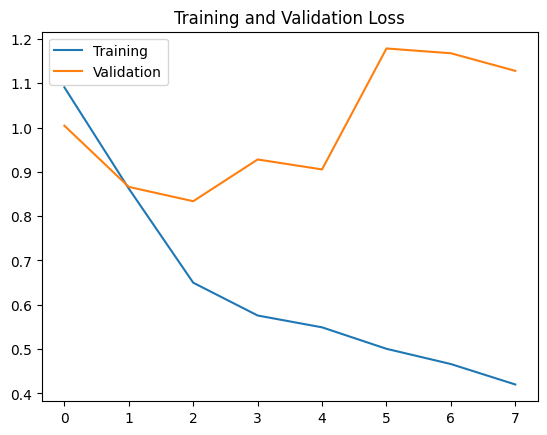

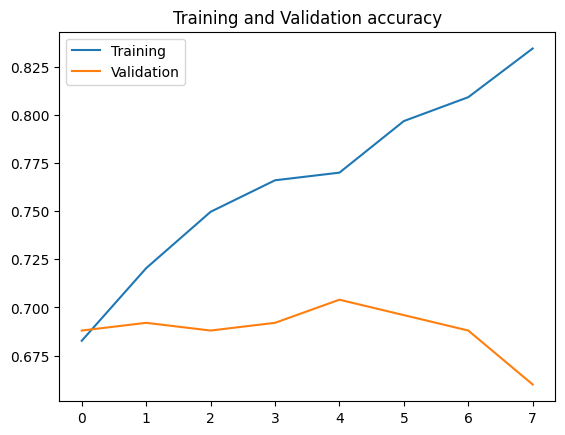

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.title('Training and Validation Loss')
plt.figure()

plt.plot(history.history['accuracy'],label='Training')
plt.plot(history.history['val_accuracy'],label='Validation')
plt.legend()
plt.title('Training and Validation accuracy')

In [19]:
# X_test_token = tokenizer.texts_to_sequences(X_test)
# X_test_token = pad_sequences(X_test_token, max_length ,padding='post')
# pred = model.predict(X_test_token)

In [20]:
# len(pred)

In [21]:
# pred = to_categorical(pred,5)

# Prediction of Test data

In [22]:
test_data = pd.read_csv("/kaggle/input/anyas-gojo-revival-space-shop/test.tsv", sep='\t')
test_data.head()

,date,time,id,reviewer name,reviewer address,contact number,variation,verified_reviews,feedback
0,29-Jul-18,16:47:11,6074908,Russell Hensley,"9059 Morales Run Suite 912\nSouth Charles, MH ...",6932290613,Heather Gray Fabric,I have the original Alexa and the Tap and so f...,1
1,28-Jul-18,17:49:58,1159008,Adam Baxter,"13728 Jones Mission Apt. 526\nSouth Tylerfurt,...",385-994-9458,Black Plus,Great product. More skills are needed. I love it.,1
2,30-Jul-18,16:46:29,1759753,Sarah Contreras,"7113 Pratt Plains\nPalmermouth, IN 02370",(738)354-8387,Configuration: Fire TV Stick,I will never buy anything Amazon makes again!T...,0
3,29-Jul-18,19:23:32,1861422,Tim Castillo,"93586 Cook Union Apt. 080\nMorganmouth, WI 51175",(294)877-6223,Black Plus,Not perfect but very good! A few times Alexa p...,1
4,28-Jul-18,16:15:25,3116018,Barry Young,69809 Harrington Meadows Apt. 256\nLake Courtn...,262-863-1391,Black Show,Kids like it for games. Showing the lyrics fo...,1


In [23]:
final_data = test_data.loc[:, ['verified_reviews']]
final_data.shape

(630, 1)

In [24]:
final_data = pd.Series(test_data['verified_reviews'])
final_data = final_data.to_numpy()

In [25]:
X_test_final = tokenizer.texts_to_sequences(final_data)
X_test_final = pad_sequences(X_test_final, max_length ,padding='post')
predictions = model.predict(X_test_final)

20/20 [==============================] - 1s 29ms/step


In [26]:
len(predictions)

630

In [27]:
final_class = []
for preds in predictions:
    final_class.append(np.argmax(preds)+1)

In [28]:
len(final_class)

630

In [29]:
# final_class

In [30]:
data = {'id': test_data['id'], 'sentiment': final_class}
sub_df = pd.DataFrame(data)
sub_df.set_index('id', inplace=True)
sub_df

,sentiment
id,
6074908,5
1159008,5
1759753,4
1861422,5
3116018,5
...,...
6856853,5
774782,5
1194506,5


In [31]:
sub_df.to_csv('submission.csv')